<a href="https://colab.research.google.com/github/jehee-lee/Aerospace_capstone_design/blob/main/%EC%8B%A4%EC%8A%B5)%EB%94%A5%EB%9F%AC%EB%8B%9D_%EA%B8%B0%EB%B0%98_%EC%9C%84%EC%B9%98_%EC%B6%94%EC%A0%95%ED%95%84%ED%84%B0_%EB%AA%A8%EB%8D%B8%EB%A7%81_(trial_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

구현 목표 모델

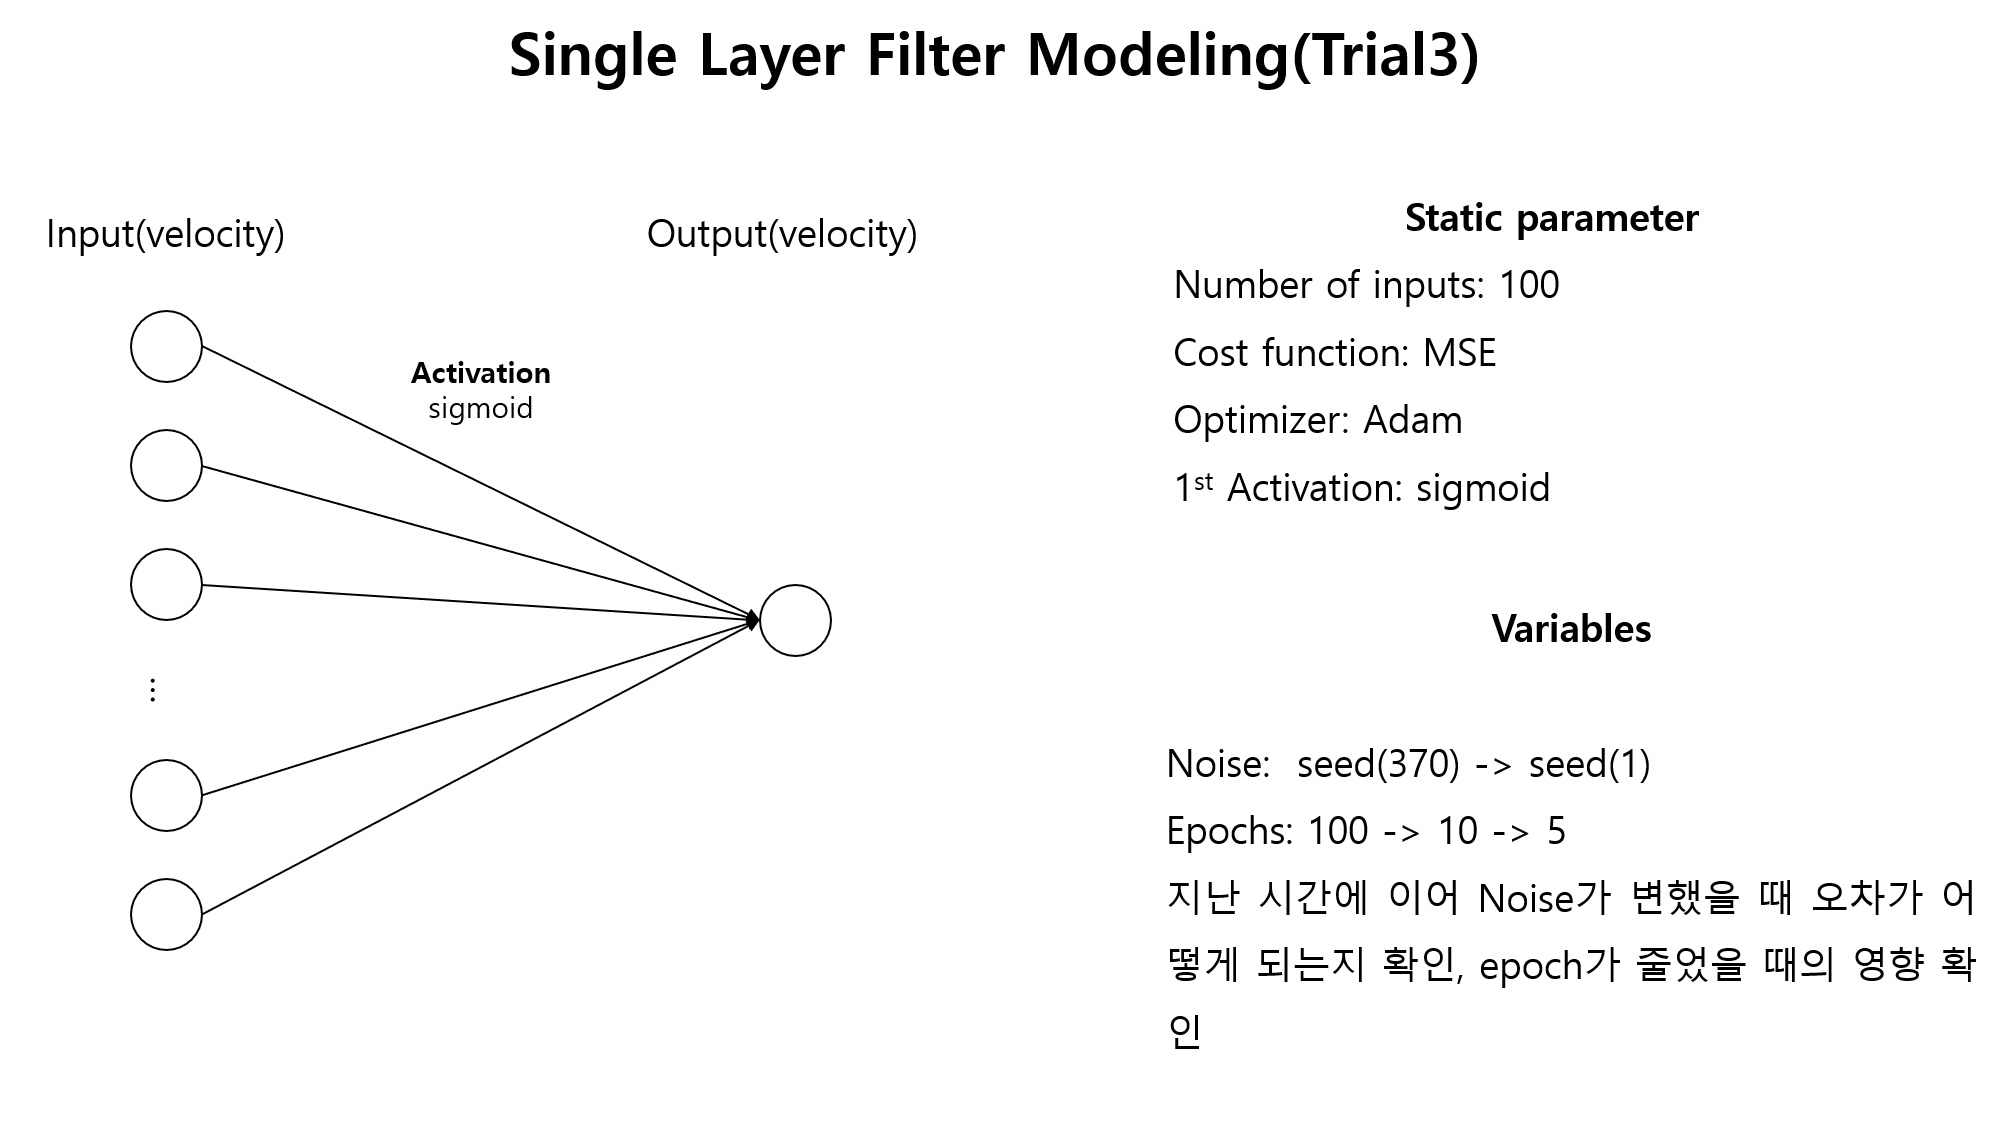

비용함수는 MSE등 임의의 비용함수 설정, Backprop방식도 임의로 설정한 뒤 학습을 진행하여 모델을 구현하는 것을 목적으로 한다. (FIR식 filtering과 같음)

데이터 생성

In [10]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(370)

A = np.zeros((2,2))
B = np.zeros((2,1))
C = np.zeros((1,2))

N = 1000 #number of timesteps

x = np.zeros((2,N+1))
x[:,0]=[0,0]
y = np.zeros((1,N))

T=50 #time will vary from 0 to T with step delt
ts = np.linspace(0, T, N+1)
del_t = T/N # delta_t = 0.05 = 50 / 1000
gamma = 0.05 #damping


A[0,0] = 1
A[0,1] = (1-gamma*del_t/2)*del_t
A[1,1] = 1 - gamma*del_t

B[0,0] = del_t**2/2
B[1,0] = del_t

C[0,0] = 1

# 1) 정규분포 노이즈

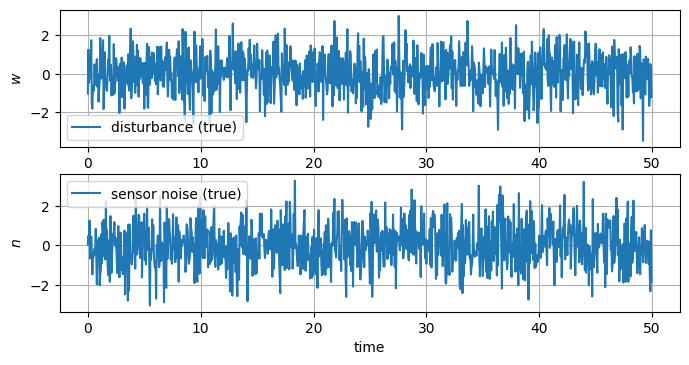

In [14]:
w = np.random.randn(1,N)
n = np.random.randn(1,N)

w_true = w.copy()
n_true = n.copy()

plt.figure(figsize=(8,4), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[:-1],w_true[0,:], label='disturbance (true)')
plt.ylabel(r"$w$")
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts[:-1],n_true[0,:], label='sensor noise (true)')
plt.xlabel('time')
plt.ylabel(r'$n$')
plt.legend()
plt.grid()
plt.show()

계측값, 위치값 설정

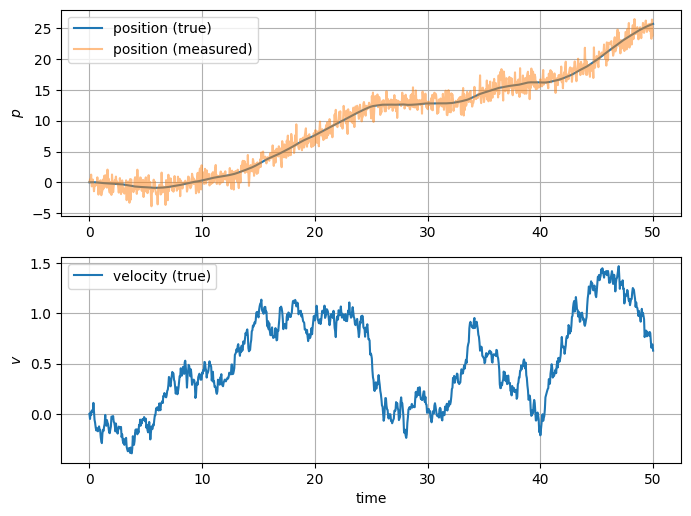

In [15]:
for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])

x_true = x.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[:-1],y[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

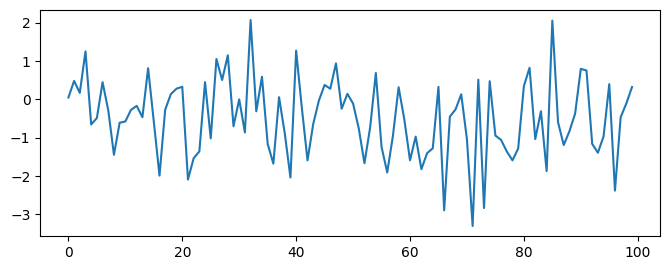

In [16]:
import tensorflow as tf
#학습할 데이터 사이즈(number of inputs)
DS = 100

train_input = np.zeros((1,DS))
#데이터 사이즈 만큼 계측 데이터 Y를 불러옴
plt.figure(figsize=(8,3), dpi=100)

train_input = y[:,:DS].copy()
#target 지정
train_target = np.array([x[0,DS+1]])
plt.plot(train_input[0,:])

filter가 될 1layer 모델 만들기

1 layer에 노드 개수는 입력값 개수와 같음

가장 기본적인 형태로 loss는 MSE, optimizer는 Adam사용

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_dim=DS)
])

model.compile(optimizer = "adam",
              loss = 'mse',
              metrics=['mae','mse'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 101       
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


학습 output이 원하는 형태로 계산되는지 확인: 1*1 array 획득

In [18]:
example_result = model.predict(train_input)
example_result

array([[-1.0678623]], dtype=float32)

In [19]:
train_target

array([-0.79178652])

In [22]:
train_input.shape, train_target.shape

((1, 100), (1,))

In [24]:
model.fit(train_input, train_target,epochs = 100)

Epoch 1/100
1/1 [==============================] - 0s 443ms/step - loss: 0.0762 - mae: 0.2761 - mse: 0.0762
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0343 - mae: 0.1853 - mse: 0.0343
Epoch 3/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0094 - mae: 0.0971 - mse: 0.0094
Epoch 4/100
1/1 [==============================] - 0s 8ms/step - loss: 2.3812e-04 - mae: 0.0154 - mse: 2.3812e-04
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0029 - mae: 0.0538 - mse: 0.0029
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0108 - mae: 0.1040 - mse: 0.0108
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0174 - mae: 0.1319 - mse: 0.0174
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0194 - mae: 0.1393 - mse: 0.0194
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0169 - mae: 0.1302 - mse: 0.0169
Epoch 10/100
1/1 [=================

# 만들어진 모델을 필터로 활용해 위치 계산

In [29]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print(i/(1000-DS))

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888


output자체는 target값과 매우 같은 값이 나왔다

In [30]:
model.predict(train_input)

array([[-0.793003]], dtype=float32)

In [31]:
output.shape

(1000,)

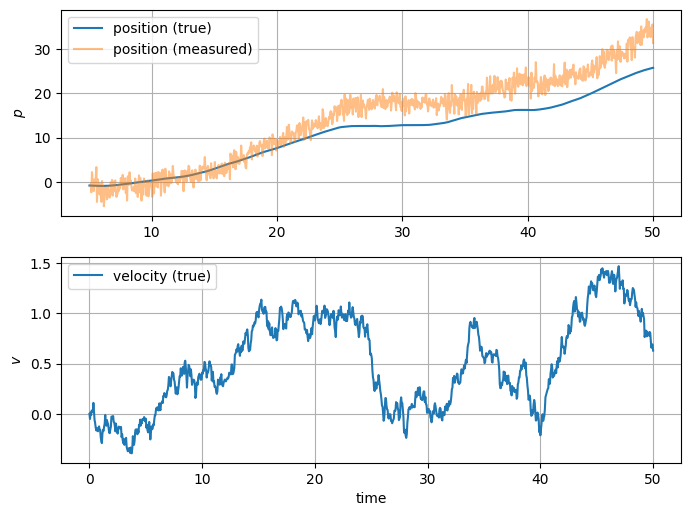

In [32]:
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

결과: 지난번과 비슷하게 drift가 나타남

# 과적합 의심 -> epoch를 10으로 줄인다면?

In [34]:
#모델 초기화
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_dim=DS)
])

model.compile(optimizer = "adam",
              loss = 'mse',
              metrics=['mae','mse'])

In [35]:
#10 epoch만 학습
model.fit(train_input, train_target,epochs = 10)

Epoch 1/10
1/1 [==============================] - 0s 332ms/step - loss: 3.1760 - mae: 1.7821 - mse: 3.1760
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 2.8607 - mae: 1.6914 - mse: 2.8607
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 2.5623 - mae: 1.6007 - mse: 2.5623
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 2.2812 - mae: 1.5104 - mse: 2.2812
Epoch 5/10
1/1 [==============================] - 0s 12ms/step - loss: 2.0175 - mae: 1.4204 - mse: 2.0175
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 1.7714 - mae: 1.3309 - mse: 1.7714
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 1.5430 - mae: 1.2422 - mse: 1.5430
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 1.3323 - mae: 1.1543 - mse: 1.3323
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 1.1392 - mae: 1.0673 - mse: 1.1392
Epoch 10/10
1/1 [==============================] - 0

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888


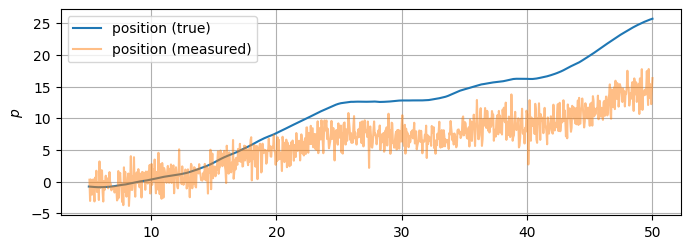

In [39]:
#모델을 통해 계산 후
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print(i/(1000-DS))

#결과 출력
plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

epoch -> 5

In [40]:
#모델 초기화
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_dim=DS)
])

model.compile(optimizer = "adam",
              loss = 'mse',
              metrics=['mae','mse'])

In [41]:
model.fit(train_input, train_target,epochs = 5)

Epoch 1/5
1/1 [==============================] - 0s 320ms/step - loss: 2.1238 - mae: 1.4573 - mse: 2.1238
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8674 - mae: 1.3665 - mse: 1.8674
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 1.6280 - mae: 1.2759 - mse: 1.6280
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 1.4059 - mae: 1.1857 - mse: 1.4059
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 1.2012 - mae: 1.0960 - mse: 1.2012


0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888


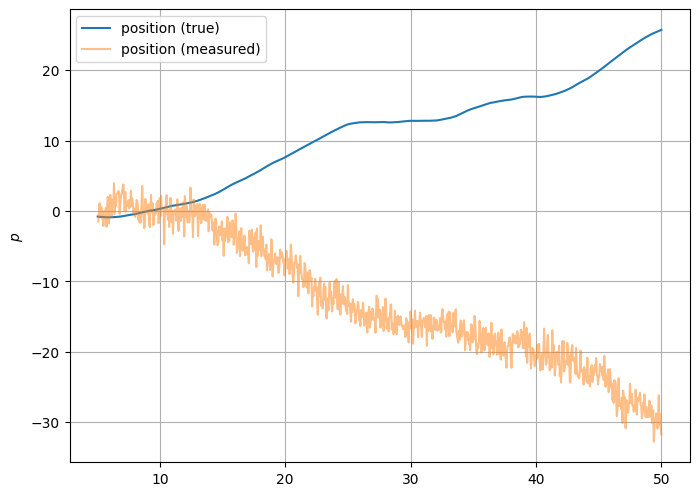

In [42]:
#모델을 통해 계산 후
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print(i/(1000-DS))

#결과 출력
plt.figure(figsize=(8,6), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.show()